# Case Study 2 - Real-time Appliance Usage Modelling

This case study demonstrates how individual appliances can be disaggregated from a building's total electricity consumption, and how deviations from normal routines can be detected automatically. The target data source is 10 second power data which can be streamed from UK smart electricity meters in real-time over the in-home ZigBee network.

The code below is part of a [iPython Notebook](http://ipython.org/notebook.html) (a.k.a [Jupyter](https://jupyter.org/)), which allows code, output and explanatory text to be included in a single file. The notebook can be opened by first installing iPython ([Anaconda](https://www.continuum.io/downloads) is recommended), opening a terminal window, navigating to the location of this notebook, and running the command: `ipython notebook`. The notebook can then be executed after installing the packages below ([NILMTK](https://github.com/nilmtk/nilmtk) etc.) by chosing 'Cell' -> 'Run All'.

In [1]:
%matplotlib inline
from datetime import time, datetime, timedelta
import numpy as np
import pandas as pd
from sklearn import mixture
import matplotlib.pyplot as plt
from matplotlib import rcParams
from pylab import arange,pi,sin,cos,sqrt
import seaborn as sns
sns.set_palette("deep", desat=.6)
sns.set_context(rc={"figure.figsize": (14, 6)})

# https://github.com/nilmtk/nilmtk/blob/master/docs/manual/user_guide/install.md
from nilmtk import DataSet
from nilmtk.datastore import HDFDataStore
from nilmtk.disaggregate.maximum_likelihood_estimation import MLE
from nilmtk.metergroup import MeterGroup

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

/Users/sobrison/anaconda/envs/nilmtk-env/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# Open UK Domestic Appliance-Level Electricity (UK-DALE) data set

In [2]:
# UK-DALE data set available from http://www.doc.ic.ac.uk/~dk3810/data/
# it can be downloaded in raw format and converted using the lines below

#from nilmtk.dataset_converters import convert_ukdale
#convert_ukdale('/Users/oliver.parson/Downloads/uk-power-data-download','/Users/oliver.parson/Downloads/ukdale.h5')

In [3]:
# the data set can then be loaded as shown below
# alternatively the data set can be downloaded directly in HDF5 format

ds = DataSet('data/ukdale.h5')

In [4]:
# load kettle and aggregate electricity data into memory

elec = ds.buildings[1].elec
kettle = elec.meters[8].power_series_all_data()
elec_mains = elec.mains().power_series_all_data()

print kettle.shape
kettle.head()

print elec_mains.shape
elec_mains.head()

(8942091,)
(56687468,)


2013-03-17 19:12:43.100000+00:00    337.880005
2013-03-17 19:12:44.100000+00:00    339.429993
2013-03-17 19:12:45.100000+00:00    340.630005
2013-03-17 19:12:46.100000+00:00    338.799988
2013-03-17 19:12:47.100000+00:00    340.880005
Name: (power, active), dtype: float32

# Plot one day of aggregate and kettle power data

It can be seen that some of the large and short spikes in usage throughout the day are a result of kettle usage.

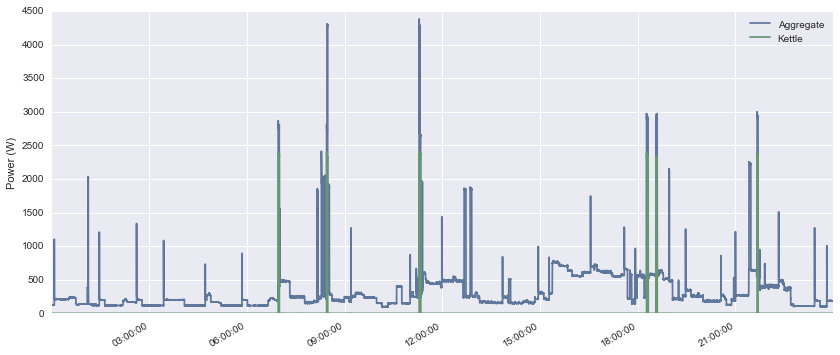

In [5]:
start = pd.Timestamp('2013-03-18')
end = pd.Timestamp('2013-03-19')
elec_mains[(elec_mains.index>start) & (elec_mains.index<end)].plot()
kettle[(kettle.index>start) & (kettle.index<end)].plot()
plt.legend(['Aggregate','Kettle'])
plt.ylabel('Power (W)')

In [10]:
# print total duration of each time series

mains_meter_group = elec.mains()
print mains_meter_group.get_timeframe()

kettle_meter = elec.meters[8]
print kettle_meter.get_timeframe()

TimeFrame(start='2013-03-17 19:12:43.100000+00:00', end='2015-01-05 06:27:12+00:00', empty=False)
TimeFrame(start='2012-11-09 22:28:18+00:00', end='2015-01-05 06:16:04+00:00', empty=False)


# Disaggregate kettle from 10 second electricity data

We can disaggregate the kettle usage by first learning a model of the kettle's electrical signature, and then matching the aggregate electricity usage against this signature.

In [11]:
# create maximum likelihood disaggregator
mle = MLE()

# set model parameters for training
mle.sampling_method = 'median'
mle.sample_period = '10s'
mle.thDelta = 2000

# train model on sub-metered data
mg = MeterGroup(meters=[kettle_meter])
mle.train(mg)

Training on chunk
Samples of onpower: 3247
Samples of offpower: 3247
Samples of duration: 3247
Training onpower
Training offpower
Training duration


# Plot learned model of kettle usage against actual kettle data

It can be seen that the 'on power' and 'off power' step changes are roughly the same magnitude and follow a similar distribution. The duration of the signature is also relatively constant, although it shows higher variation than the power step changes as the kettle boiling time is dependent on the amount of water in the kettle.

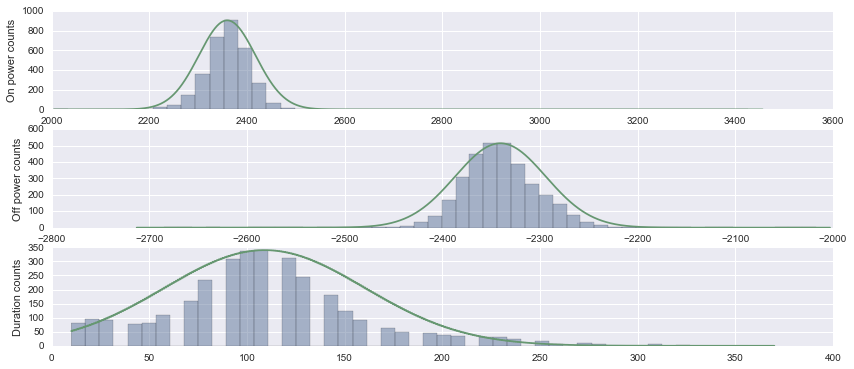

In [12]:
mle.featuresHist()

In [ ]:
# set disaggregation parameters 
mle.powerNoise = 2200 # Background noise in the main
mle.powerPair = 200 # Max diff between onpower and offpower
mle.timeWindow = 250 # To avoid high computation
mle.thLikelihood = 1e-10 # Threshold above which events are classed as kettle

# disaggregate kettle and save results to file
disag_store_path = 'data/ukdale_disag_3.h5'
disag_store = HDFDataStore(disag_store_path, 'w')
mle.disaggregate(mains_meter_group, disag_store)

In [10]:
# open disaggregated data file
disag_ds = DataSet(disag_store_path)

# print meters
disag_ds.buildings[1].elec.meters

[ElecMeter(instance=1, building=1, dataset='NILMTK_MLE_2015-10-09T09:22:36', site_meter, appliances=[]),
 ElecMeter(instance=2, building=1, dataset='NILMTK_MLE_2015-10-09T09:22:36', appliances=[Appliance(type='kettle', instance=1)])]

In [9]:
# load disaggregated kettle time series into memory

kettle_disag = disag_ds.buildings[1].elec.meters[1].power_series_all_data().sort_index()
print kettle_disag.shape
print kettle_disag.head()

agg_psad = disag_ds.buildings[1].elec.meters[0].power_series_all_data().sort_index()
print agg_psad.shape
print agg_psad.head()

NameError: name 'disag_ds' is not defined

# Plot aggregate data, sub-metered kettle data, and disaggregated kettle data

It can be seen that in the case below, all uses of the kettle are successfully disaggregated. Furthermore, even the short duration spike is successfully disaggregated as a result of a strong match of the 'on power' and 'off power' step changes.

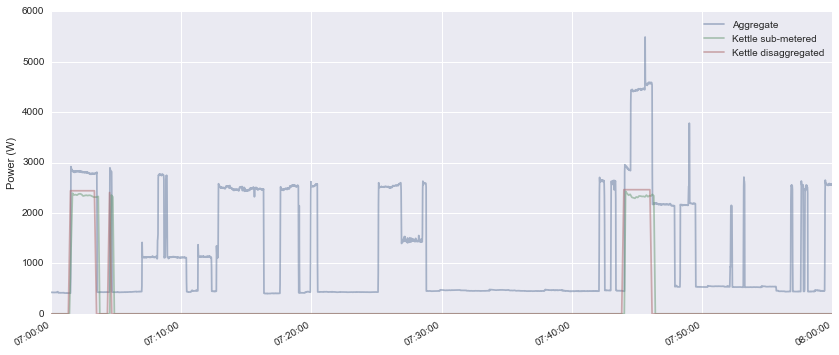

In [12]:
start = pd.Timestamp('2013-03-19 07:00')
end = pd.Timestamp('2013-03-19 08:00')
agg_psad[start:end].plot(alpha=0.5)
kettle[start:end].plot(alpha=0.5)
kettle_disag[start:end].plot(alpha=0.5)
plt.legend(['Aggregate','Kettle sub-metered','Kettle disaggregated'])
plt.ylabel('Power (W)')

In [13]:
disag_ds.store.close()